# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

# Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

## Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

Num days: 84


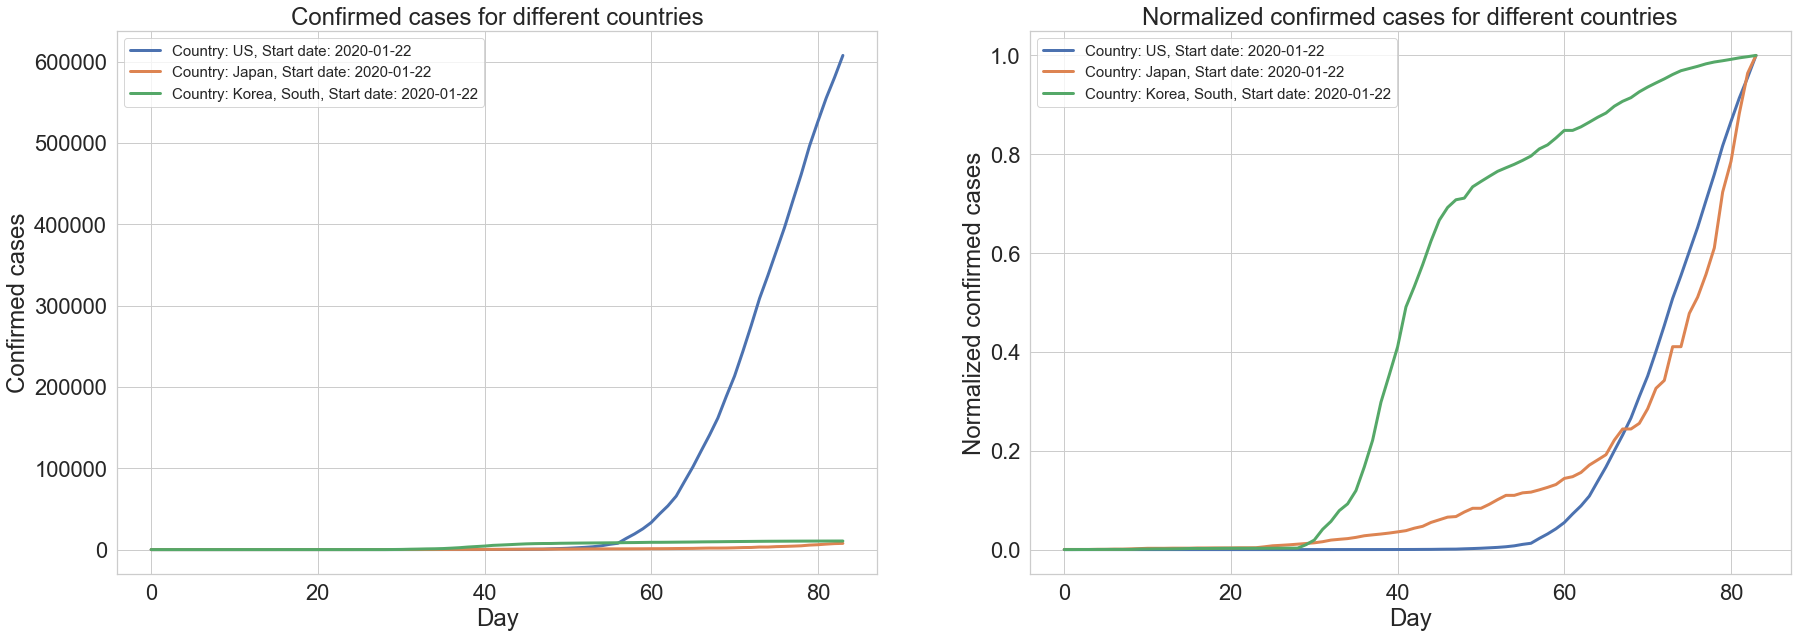

In [2]:
import pandas as pd
import sys
sys.path.insert(0,'../')
from data import plot_countries_all_plus_normalize_1 as plot
from data import save_country_data_1 as save
df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# plot
plot(df, ['US', 'Japan', 'Korea, South'])
# save data
save(df, ['US', 'Japan', 'Korea, South'])

In [63]:
import numpy as np
import matplotlib.pyplot as plt

In [79]:
# Setting
sigma = 100   # data noise

# prepare data
df = pd.read_csv('US.csv',header=None)
# t_c = [float(t) for t in df[0][:50]]
# t_v = [float(t) for t in df[0][50:]]
# data = np.array(df[1])
# data_c = np.array(df[1][:50])
# data_v = np.array(df[1][50:])
data = np.array(df)
data_c = data[:50,:]
data_v = data[50:,:]


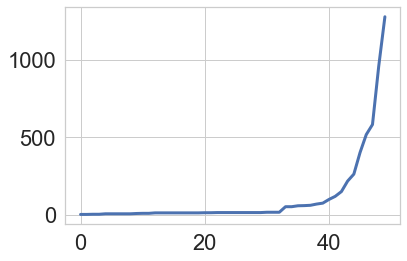

In [86]:
plt.plot(data_c[:,0],data_c[:,1])

In [80]:
# prepare model
C_0 = data[0,1]

def model1(t, theta):
    r = theta[0]
    p = theta[1]
    m = 0.
    cm = 0.
    if p < 1. - 1.e-5:
        m = 1. / (1. - p)
        cm = np.power(C_0, 1./m)
    C = []
    for i in range(len(t)):
        if p < 1.e-5:
            C.append(r * t[i] + C_0)
        elif p > 1. - 1.e-5:
            C.append(C_0 * np.exp(r * t[i]))
        else:
            C.append(np.power(r * t[i] / m + cm, m))        
    return np.array(C)

In [94]:
# prepare Bayessian MCMC
transition_model = lambda theta: np.random.normal(theta,[0.05,0.05],(2,))

def prior(theta):
    if theta[0]<0 or theta[1]<0 or theta[1]>1:   # r>0  0<=p<=1
        return 0
    return 1

def log_likelihood(theta, data):
    # theta[0]=r, theta[1]=p
    tdata = data[:,0]
    ydata = data[:,1]
    return np.sum(-np.log(sigma * np.sqrt(2*np.pi) )-((ydata-model1(tdata,theta))**2) / (2*sigma**2))

def acceptance_rule(x, x_new):     # acceptance rule under log likelihood
    if x_new>x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))
    
def metropolis_hastings(log_likelihood,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    theta = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        theta_new = transition_model(theta)    
        lik = log_likelihood(theta,data)
        lik_new = log_likelihood(theta_new,data) 
        if (acceptance_rule(lik + np.log(prior(theta)),lik_new + np.log(prior(theta_new)))):            
            theta = theta_new
            accepted.append(theta_new)
        else:
            rejected.append(theta_new)            
                
    return np.array(accepted), np.array(rejected)
    


## Calibration

In [95]:
np.random.normal([1,0],[0.3,0.2],(2,))

array([0.79313569, 0.22622537])

In [96]:
accepted, rejected = metropolis_hastings(log_likelihood,prior,transition_model,[1, 0], 50000,data_c,acceptance_rule)



/Users/mathew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [97]:
print(accepted.shape)


(282, 2)


Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

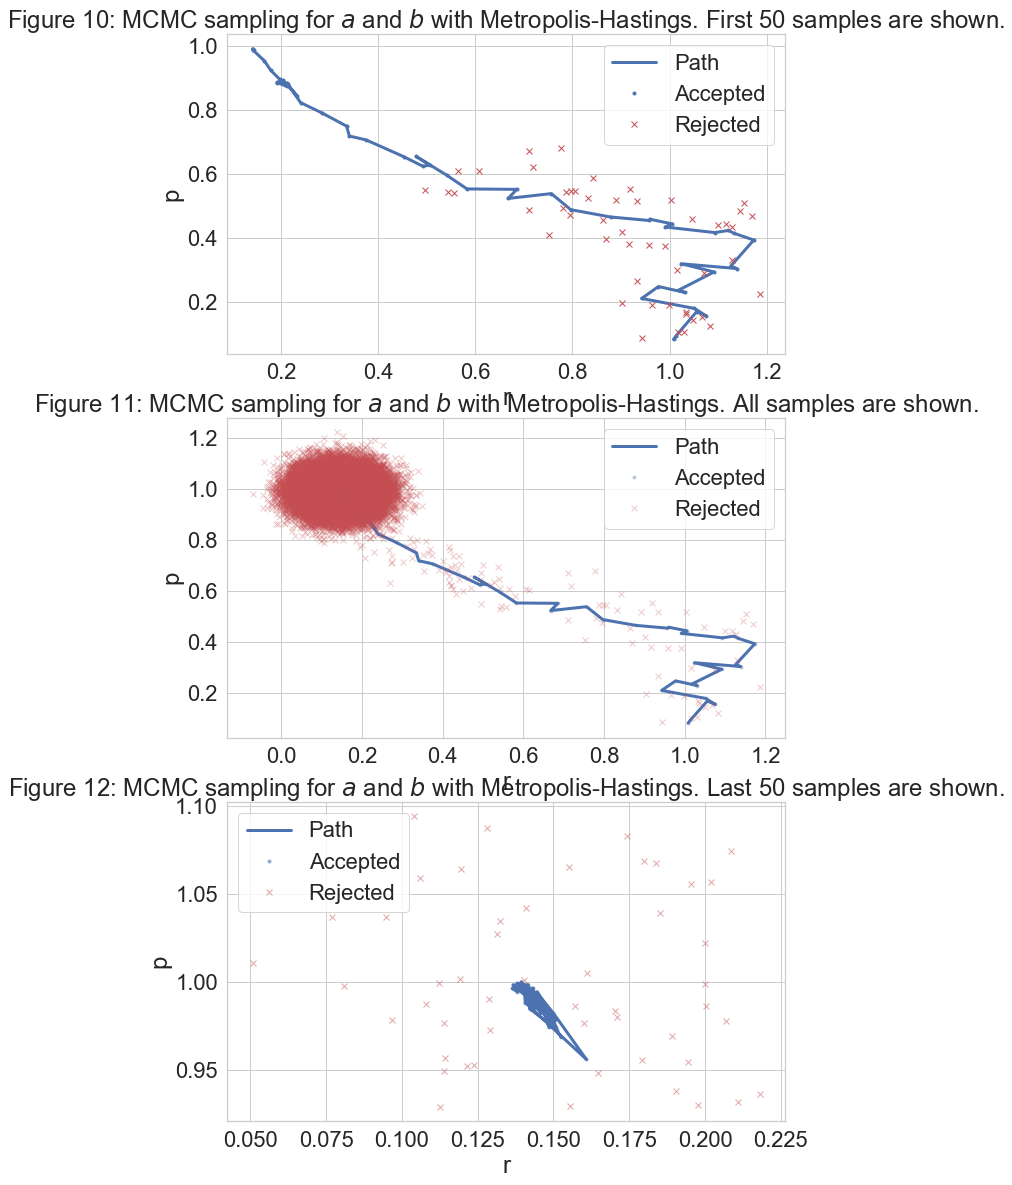

In [98]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("r")
ax.set_ylabel("p")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("r")
ax.set_ylabel("p")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("r")
ax.set_ylabel("p")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.") 

## Validation

# References

- **Viboud et al 2015** Viboud, C., Simonsen, L. and Chowell, G., 2016. A generalized-growth model to characterize the early ascending phase of infectious disease outbreaks. Epidemics, 15, pp.27-37.